Imports and set-up

In [1]:
# makes figures interactable
%matplotlib notebook

# reloads changes to external files without restarting the notebook
%load_ext autoreload
%autoreload 2

#import math and plotting tools
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng()

#import brain area module
from brain import BrainArea

We will train the network to simulate the following state machine, which recognizes the language consisting of strings containing an even number of zeros.

![image](fsm_zeros.png)

Define parameters of the model and instantiate an input area and two brain areas

In [56]:
n_inputs = 1000
n_neurons = 1000
cap_size = 30
density = 0.3

n_symbols = 2 + 1
symbols = np.zeros((n_symbols, n_inputs))
for i in range(n_symbols):
    symbols[i, i*cap_size : (i+1) * cap_size] = 1.

n_states = 2 + 2
states = np.zeros((n_states, n_neurons))
for i in range(n_states):
    states[i, i*cap_size : (i+1) * cap_size] = 1.

arcs = np.zeros((n_states, n_symbols, n_neurons))
for i in range(n_states):
    for j in range(n_symbols):
        arcs[i, j, (i * n_symbols + j) * cap_size : (i * n_symbols + j + 1) * cap_size] = 1.

state_area = BrainArea(n_neurons, n_neurons, cap_size, density, plasticity=1e-1, norm_init=False)
arc_area = BrainArea([n_inputs, n_neurons], n_neurons, cap_size, density, plasticity=1e-1, norm_init=False)
state_area.recurrent_weights = np.zeros_like(state_area.recurrent_weights)
arc_area.recurrent_weights = np.zeros_like(arc_area.recurrent_weights)

Define the transitions of the state machine

In [57]:
#[initial state, symbol, new state]
transition_list = [[0, 0, 1], [0, 1, 0], [0, 2, 2], [1, 0, 0], [1, 1, 1], [1, 2, 3]]

Train the network by presenting the inputs and output of each transition

In [58]:
state_area.inhibit()
arc_area.inhibit()
for _ in range(15):
    for transition in transition_list:
        arc_area.set_input([symbols[transition[1]], states[transition[0]]], input_area=[0, 1])
        arc_area.fire(arcs[transition[0], transition[1]])

        state_area.set_input(arc_area.read())
        state_area.fire(states[transition[2]])    

        state_area.inhibit()
        arc_area.inhibit()

Test whether the network correctly classifies an arbitrary string

In [59]:
# positive example
# sequence = [1, 0, 0, 1, 0, 0, 2] 
# negative example
sequence = [0, 0, 1, 1, 0, 0, 0, 1, 2]
outputs = np.zeros((len(sequence)+1, 2, n_neurons))

state_area.inhibit()
arc_area.inhibit()
state_area.fire(states[0], update=False)
state_area.inhibit()
outputs[0, 0] = states[0]
for j in range(len(sequence)):    
    arc_area.inhibit()
    arc_area.set_input([symbols[sequence[j]], state_area.read()], input_area=[0, 1])
    arc_area.step(update=False)

    state_area.inhibit()
    
    state_area.set_input(arc_area.read())
    state_area.step(update=False)
    
    outputs[j+1, 0] = state_area.read()
    outputs[j+1, 1] = arc_area.read()
state_area.inhibit()
arc_area.inhibit()

<IPython.core.display.Javascript object>


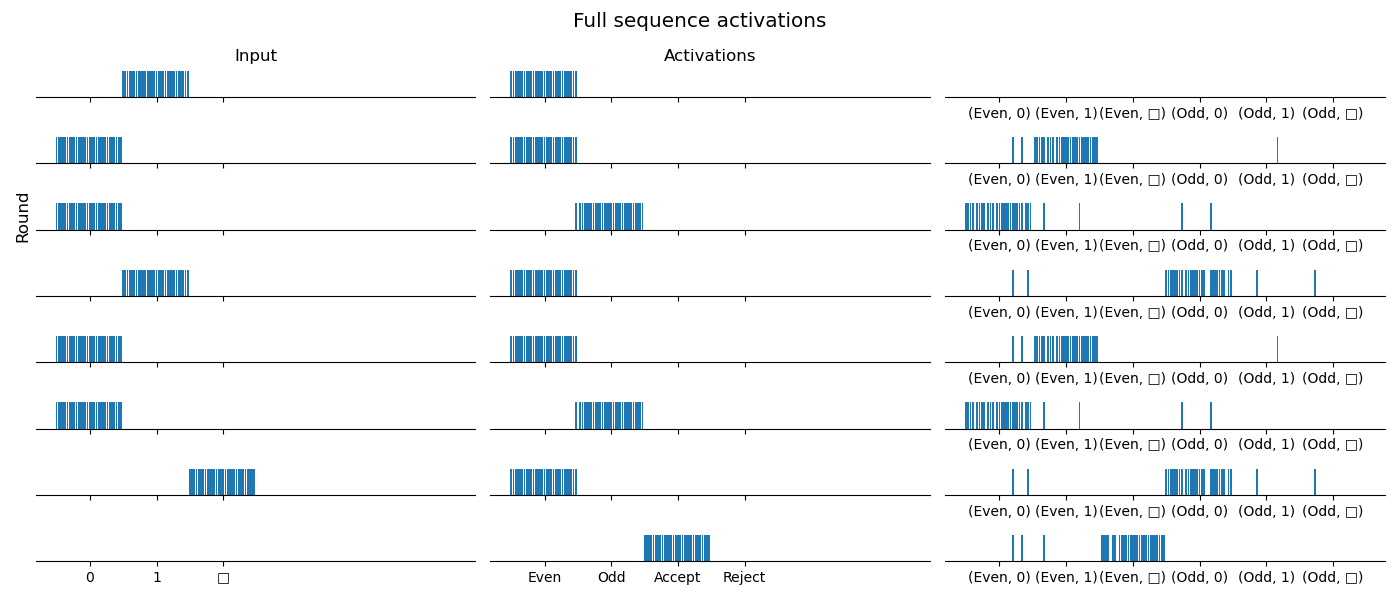

In [13]:
fig, axes = plt.subplots(len(sequence)+1, 3, figsize=(14, 6), sharey=True)
for i in range(len(sequence)):
    axes[i, 0].bar(np.arange(180), symbols[sequence[i]][:180])
axes[-1, 0].bar(np.arange(180), np.zeros(180))
for i in range(len(sequence)+1):
    axes[i, 1].bar(np.arange(180), outputs[i, 0][:180])
    axes[i, 2].bar(np.arange(180), outputs[i, 1][:180])
axes[0, 0].set_title('Input')
axes[0, 1].set_title('Activations')
axes[2, 0].set_ylabel('Round', fontsize='large')
fig.suptitle('Full sequence activations', fontsize='x-large')

for ax in axes[:, 0]:
    ax.set_xticks([15, 45, 75])
    ax.set_xticklabels([])
    
for ax in axes[:, 1]:
    ax.set_xticks([15, 45, 75, 105])
    ax.set_xticklabels([])
    
for ax in axes[:, 2]:
    ax.set_xticks([15 + i * cap_size for i in range(n_symbols * (n_states - 2))])
    ax.set_xticklabels(['(' + state +', ' + symb + ')' for state in ['Even', 'Odd'] for symb in ['0', '1', '□']])

axes[-1, 0].set_xticklabels(['0', '1', '□'])

axes[-1, 1].set_xticklabels(['Even', 'Odd', 'Accept', 'Reject'])

for ax in axes.flatten():
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
fig.tight_layout()

Now, let's try a different state machine. This one will accept strings whose number of 1's is a multiple of three:

![image](fsm_ones.png)

In [54]:
n_states = 3 + 2
states = np.zeros((n_states, n_neurons))
for i in range(n_states):
    states[i, i*cap_size : (i+1) * cap_size] = 1.

arcs = np.zeros((n_states-2, n_symbols, n_neurons))
for i in range(n_states-2):
    for j in range(n_symbols):
        arcs[i, j, (i * n_symbols + j) * cap_size : (i * n_symbols + j + 1) * cap_size] = 1.

state_area = BrainArea(n_neurons, n_neurons, cap_size, density, plasticity=1e-1, norm_init=False)
arc_area = BrainArea([n_inputs, n_neurons], n_neurons, cap_size, density, plasticity=1e-1, norm_init=False)
arc_area.recurrent_weights = np.zeros_like(arc_area.recurrent_weights)

In [55]:
transition_list = [[0, 0, 0], [0, 1, 1], [0, 2, 3], [1, 0, 1], [1, 1, 2], [1, 2, 4], [2, 0, 2], [2, 1, 0], [2, 2, 4]]

Train the network by presenting the inputs and output of each transition

In [56]:
state_area.inhibit()
arc_area.inhibit()
for _ in range(20):
    for transition in transition_list:
        arc_area.set_input([symbols[transition[1]], states[transition[0]]], input_area=[0, 1])
        arc_area.fire(arcs[transition[0], transition[1]])

        state_area.set_input(arc_area.read())
        state_area.fire(states[transition[2]])    

        state_area.inhibit()
        arc_area.inhibit()

Test whether the network correctly classifies an arbitrary string

In [59]:
# negative example
# sequence = [1, 0, 0, 1, 0, 0, 2] 
# positive example
sequence = [0, 0, 1, 1, 0, 0, 0, 1, 2]
outputs = np.zeros((len(sequence)+1, 2, n_neurons))

state_area.inhibit()
arc_area.inhibit()
state_area.fire(states[0], update=False)
outputs[0, 0] = states[0]
for j in range(len(sequence)):
    arc_area.set_input([symbols[sequence[j]], state_area.read()], input_area=[0, 1])
    arc_area.step(update=False)

    state_area.set_input(arc_area.read())
    state_area.step(update=False)
    outputs[j+1, 0] = state_area.read()
    outputs[j+1, 1] = arc_area.read()
state_area.inhibit()
arc_area.inhibit()

<IPython.core.display.Javascript object>


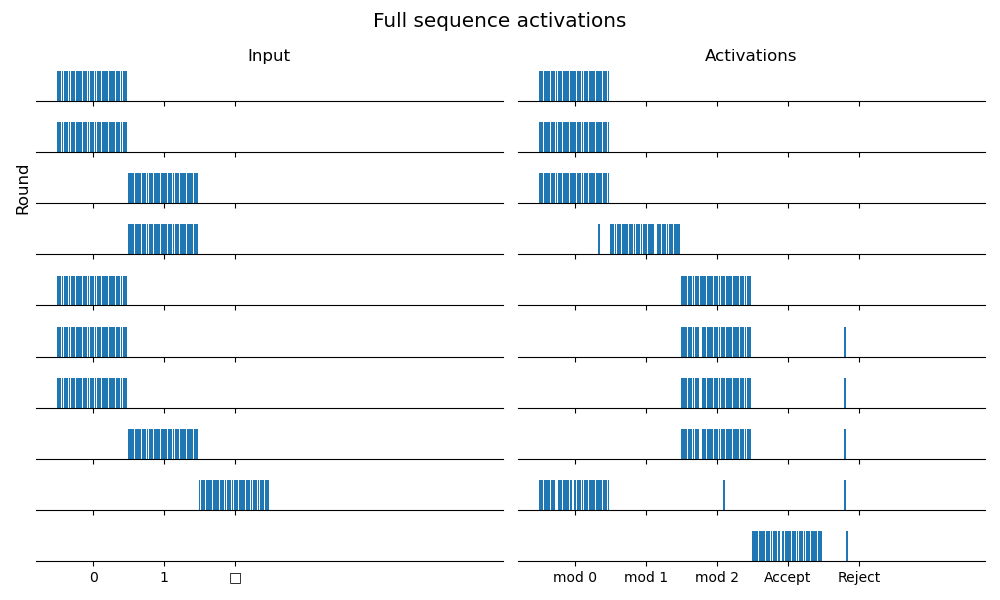

In [65]:
fig, axes = plt.subplots(len(sequence)+1, 2, figsize=(10, 6), sharey=True)
for i in range(len(sequence)):
    axes[i, 0].bar(np.arange(180), symbols[sequence[i]][:180])
axes[-1, 0].bar(np.arange(180), np.zeros(180))
for i in range(len(sequence)+1):
    axes[i, 1].bar(np.arange(180), outputs[i, 0][:180])
#     axes[i, 2].bar(np.arange(180), outputs[i, 1][:180])
axes[0, 0].set_title('Input')
axes[0, 1].set_title('Activations')
axes[2, 0].set_ylabel('Round', fontsize='large')
fig.suptitle('Full sequence activations', fontsize='x-large')

for ax in axes[:, 0]:
    ax.set_xticks([15 + i * cap_size for i in range(n_symbols)])
    ax.set_xticklabels([])
    
for ax in axes[:, 1]:
    ax.set_xticks([15 + i * cap_size for i in range(n_states)])
    ax.set_xticklabels([])
    
# for ax in axes[:, 2]:
#     ax.set_xticks([15 + i * cap_size for i in range(n_symbols * (n_states - 2))])
#     ax.set_xticklabels(['(' + state +', ' + symb + ')' for state in ['m0', 'm1', 'm2'] for symb in ['0', '1', '□']])

axes[-1, 0].set_xticklabels(['0', '1', '□'])

axes[-1, 1].set_xticklabels(['mod 0', 'mod 1', 'mod 2', 'Accept', 'Reject'])

for ax in axes.flatten():
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
fig.tight_layout()